DAY 09 - Mar 5, 2017

- In this notebook, we use neural networks from the scikit-learn package to train a model for prediction to enter the [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/data) kaggle competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

import math
import os

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [15,6]

### Load data

In [3]:
input_dir = "./data/"

# Load my data
train_file = os.path.join(input_dir, "train.csv")
test_file = os.path.join(input_dir, "test.csv")

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)


# The features
features = train.columns[1:]
n_features = len(features)


# Create different data sets i.e. for training & validating
dim = train.shape
train_num = int(dim[0] * 0.8)
val_num = dim[0] - train_num

X_train, y_train = train.iloc[:train_num,1:], train.iloc[:train_num,0]
X_val, y_val = train.iloc[train_num:,1:], train.iloc[train_num:,0]


print("feature:", n_features)
print("train:", train_num)
print("valid:", val_num)

feature: 784
train: 33600
valid: 8400


### Neural Network (Multi-layer Perceptron classifier)

`MLPClassifier` documentation is found [here](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). `alpha` is the L2 penalty (regularization term) parameter, `hidden_layer_sizes` specifies the number of hidden layers and the number of nodes in each layer, `random_state` is a seed for the random number generator.

**How to specify the hidden layer?**

According to [doug (2010)](http://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw):

> In sum, for most problems, one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: (i) number of hidden layers equals one; and (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.

In [4]:
n_outputs = len(set(y_train))
n_neurons = int((n_outputs + n_features)/2)

print("The mean of %i inputs and %i outputs is %i neurons" % (n_features, n_outputs, n_neurons))

The mean of 784 inputs and 10 outputs is 397 neurons


In [5]:
# alpha = L2 penalty (regularization term) parameter
# hidden_layer_sizes = length=n_layers - 2, default (100,)
# random_state = seed for random number generator
clf = MLPClassifier(alpha=1e-5,
                    hidden_layer_sizes=(n_neurons,), random_state=1)

clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(397,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Some features more informative than others

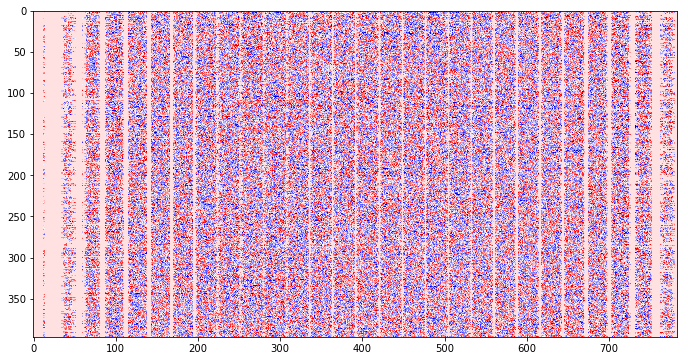

In [6]:
a = clf.coefs_[0]
a = np.matrix.transpose(a)

plt.imshow(a, cmap=plt.cm.seismic, alpha=1)

### Evaluation 
Accuracy:

In [7]:
sum(clf.predict(X_val) == y_val) / len(y_val)

0.96547619047619049

In [8]:
test_yhat = clf.predict(test)

pd.DataFrame({"ImageId":test.index+1, "Label":test_yhat}).to_csv("digitrecognizer-nn_submission.csv", index=False)

!head digitrecognizer-nn_submission.csv

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


Kaggle: "Your submission scored 0.96214, which is an improvement of your previous score of 0.95871. Great job!"

### Training on the whole set
We now retrain on everything (for more samples):

In [9]:
X = X_train.append(X_val)
y = y_train.append(y_val)


clf_all = MLPClassifier(alpha=1e-5,
                        hidden_layer_sizes=(n_neurons,), random_state=1)
clf_all.fit(X, y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(397,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [10]:
testall_yhat = clf_all.predict(test)

pd.DataFrame({"ImageId":test.index+1, "Label":testall_yhat}).to_csv("digitrecognizer-nn-all_submission.csv", index=False)

!head digitrecognizer-nn-all_submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


Kaggle: "Your submission scored 0.96400, which is an improvement of your previous score of 0.96214. Great job!"

### Diff between 80% and 100% use of dataset

In [11]:
# Combine trained on 80% and 100% of data
df = pd.DataFrame({"eighty" : test_yhat, "all" : testall_yhat, "diff" : test_yhat != testall_yhat})
print(df.head())

## HOw many differences?
df_diff = df[df["diff"]]
df_diff.shape

   all   diff  eighty
0    2  False       2
1    0  False       0
2    9  False       9
3    0   True       9
4    3  False       3


(1182, 3)

In [15]:
# Tidy dataframe for plotting

# Count each category
df_diff_sizes = df_diff.drop("diff", axis=1).groupby(["all", "eighty"]).size()
df_diff_sizes = df_diff_sizes.reset_index(name='size').sort_values(by="size", ascending=False)

df_diff_sizes["label"] = df_diff_sizes["eighty"].map(str) + "," + df_diff_sizes["all"].map(str)

df_diff_sizes.head()

,all,eighty,size,label
76,9,4,87,"4,9"
80,9,8,56,"8,9"
43,5,3,55,"3,5"
47,5,8,53,"8,5"
31,3,8,51,"8,3"


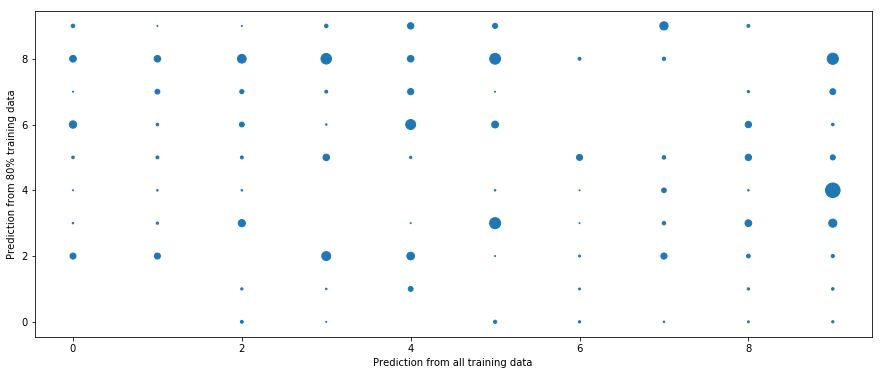

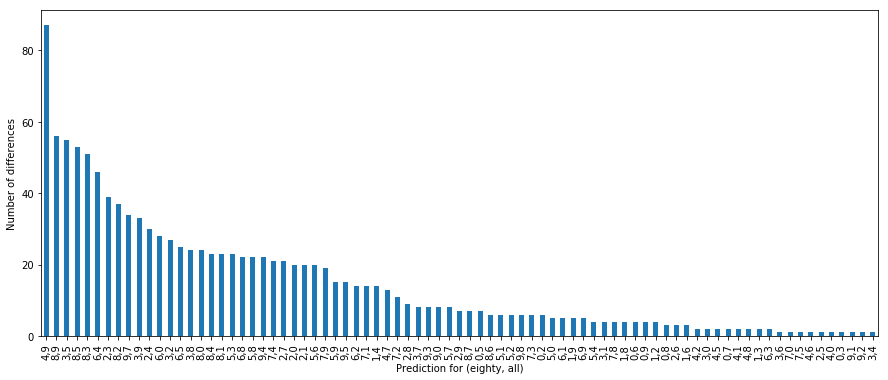

In [25]:
df_diff_sizes.plot.scatter(x="all", y="eighty", s=df_diff_sizes["size"]**1.2)
plt.xlabel("Prediction from all training data")
plt.ylabel("Prediction from 80% training data")

df_diff_sizes[["label", "size"]].plot.bar(x="label", legend=False)
plt.xlabel("Prediction for (eighty, all)")
plt.ylabel("Number of differences")

- Most inconsistency between 4 and 9
- Use all data